In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import os
import random
import shutil
from PIL import Image
import matplotlib.patches as mpatches
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_val_predict
import math
from sklearn.model_selection import KFold

In [1]:
N1 = (69225 + 699531) % 2
N1

0

In [3]:
N2 = (69225 + 699531) % 3
N2

0

### Calculando a área da Celula

In [3]:
def calculaAreaPerimetroImagem(img_cv2):
  
  imagem_cinza = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2GRAY)
  _, mascara_binaria = cv2.threshold(imagem_cinza, 1, 255, cv2.THRESH_BINARY)
  contornos, _ = cv2.findContours(mascara_binaria, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  mascara_colorida = np.zeros_like(img_cv2)
  cv2.drawContours(mascara_colorida, contornos, -1, (255, 255, 255), thickness=cv2.FILLED)

  # Exibir a imagem original, a máscara e a parte colorida
  area_branca = np.sum(mascara_binaria == 255)
  
  
  total_perimetro = 0
  
  for contorno in contornos:
    perimeter = cv2.arcLength(contorno, closed=True)
    total_perimetro += perimeter
  
  return area_branca, round(total_perimetro, 2)


### Calculando Compacidade

In [4]:
# 4 PI area / perimetro^2
def calcularCompacidade(img_cv2):
  area, perimetro = calculaAreaPerimetroImagem(img_cv2)
  
  compacidade = (area * (4 * math.pi)) / (perimetro**2)  
  
  return round(compacidade, 4)

### Calculando Excentricidade

In [5]:
def calcularExcentricidades(img_cv2):
  
  imagem_cinza = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2GRAY)
  _, mascara_binaria = cv2.threshold(imagem_cinza, 1, 255, cv2.THRESH_BINARY)
  contornos, _ = cv2.findContours(mascara_binaria, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  maior_contorno = max(contornos, key=cv2.contourArea)

    
  if len(maior_contorno) >= 5:
    # (elipse_x, elipse_y), (eixo_maior, eixo_menor), _ = cv2.fitEllipse(maior_contorno)
    elipse = cv2.fitEllipse(maior_contorno)
    eixo_maior = max(elipse[1])
    eixo_menor = min(elipse[1])
    # Restante do seu código
  else:
    return 0


  # Calcular excentricidade
  # 1-menor^2 / 1-maior^2
  
  excentricidade = 1 - ((eixo_menor ** 2) / (eixo_maior ** 2))
  
  # if(eixo_maior != 0 and eixo_menor != 0):
  #   value_mid = round((eixo_menor / eixo_maior)**2, 2)
  # else:
  #   return 0
  
  # excentricidade = round(np.sqrt(value_mid-1),2)
  
  return excentricidade

### Gerar CSV

In [6]:
csv = {'id_cel': [],
       'label': [],
       'area': [],
       'compacidade': [],
       'excentricidade': [],
       }

path_dataset_segmentation = "../data/segmentation_dataset_categorical/"


for pasta_atual, subpastas, arquivos in os.walk(path_dataset_segmentation):
    for arquivo in arquivos:
        caminho_completo = os.path.join(pasta_atual, arquivo)
        
        imagem = cv2.imread(caminho_completo)
        
        
        area, _ = calculaAreaPerimetroImagem(imagem)
        
        nomeSplit = caminho_completo.split("\\")
        classeSpli = nomeSplit[0].split("/")
        nomeCel = nomeSplit[1].replace(".png", "")
        nomeClasse = classeSpli[len(classeSpli)-1]
        csv['id_cel'].append(nomeCel)

        
        csv['area'].append(round(area,2))
        csv['label'].append(nomeClasse)
        csv['compacidade'].append(calcularCompacidade(imagem))
        csv['excentricidade'].append(calcularExcentricidades(imagem))
          
  
       
df = pd.DataFrame(csv)
df.to_csv('../csv_pt2_categorical.csv', index=False)       


In [7]:
df = pd.read_csv("../csv_pt2_categorical.csv")

### Normalizar CSV

In [9]:
from sklearn.preprocessing import MinMaxScaler
# Carregue o CSV para um DataFrame
df = pd.read_csv('../csv_pt2_categorical.csv')

# Selecione apenas as colunas que você deseja normalizar
colunas_para_normalizar = ['area', 'compacidade', 'excentricidade']
dados_normalizar = df[colunas_para_normalizar]

# Inicialize o objeto MinMaxScaler
scaler = MinMaxScaler()

# Ajuste e transforme os dados
dados_normalizados = scaler.fit_transform(dados_normalizar)

# Substitua as colunas no DataFrame pelos dados normalizados
df[colunas_para_normalizar] = dados_normalizados

# Agora, df contém os dados normalizados
# Você pode salvar o DataFrame de volta em um novo arquivo CSV se desejar
df.to_csv('../csv_pt2_categorical.csv', index=False)

### Gerando scatterplot com as caracteristicas calculadas

#### Area X Compacidade

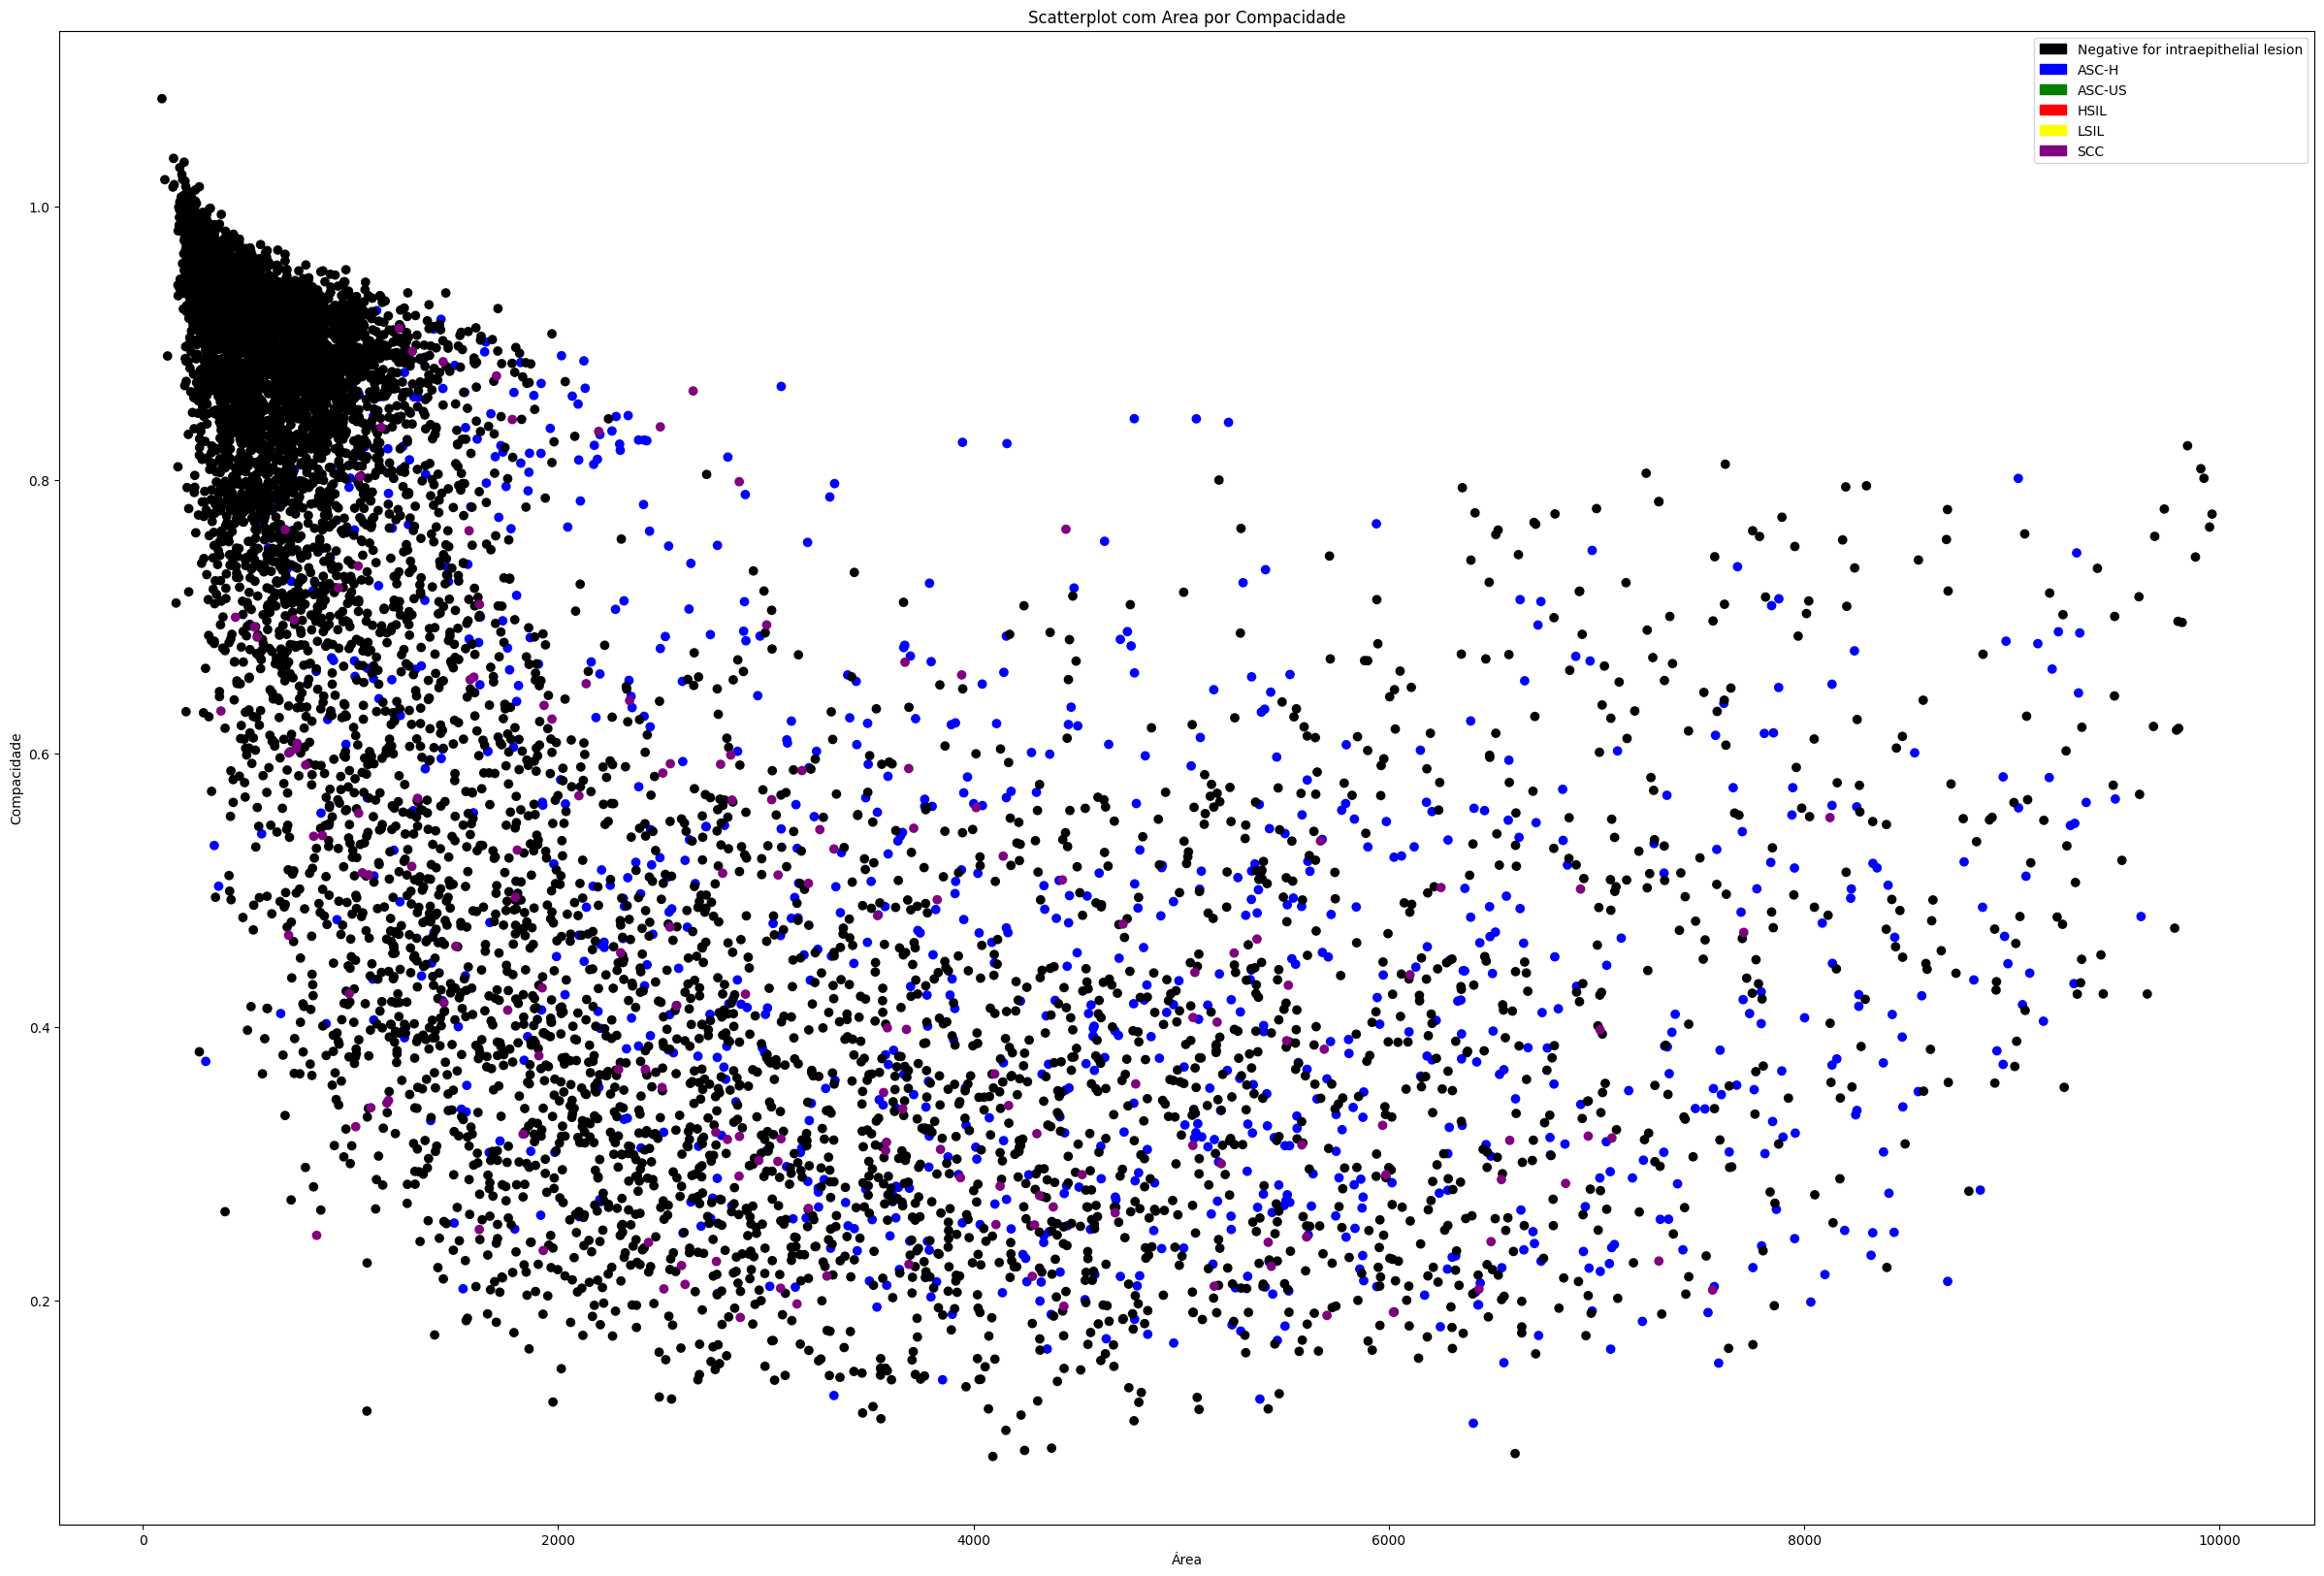

In [8]:
cores = {'Negative for intraepithelial lesion': 'black', 'ASC-H': 'blue', "ASC-US":"green", 'HSIL': 'red', 'LSIL': 'yellow','SCC': 'purple',}
# cores = {'Negativo': 'black', 'Positivo': 'blue'}

# Adicionar uma coluna 'Cor' com as cores correspondentes às classes
df['Cor'] = df['label'].map(cores)
plt.figure(figsize=(30, 20))

# Plotar o scatterplot
plt.scatter(df['area'], df['compacidade'], c=df['Cor'], label=df['label'])

# Tamanho da Figura

# Adicionar rótulos e título
plt.xlabel('Área')
plt.ylabel('Compacidade')
plt.title('Scatterplot com Area por Compacidade')

# Criando patches das legendas
patches = [mpatches.Patch(color=color, label=label) for label, color in cores.items()]

# Adicionar uma legenda
plt.legend(handles=patches)

# Exibir o gráfico
plt.show()

#### Area x Excentricidade

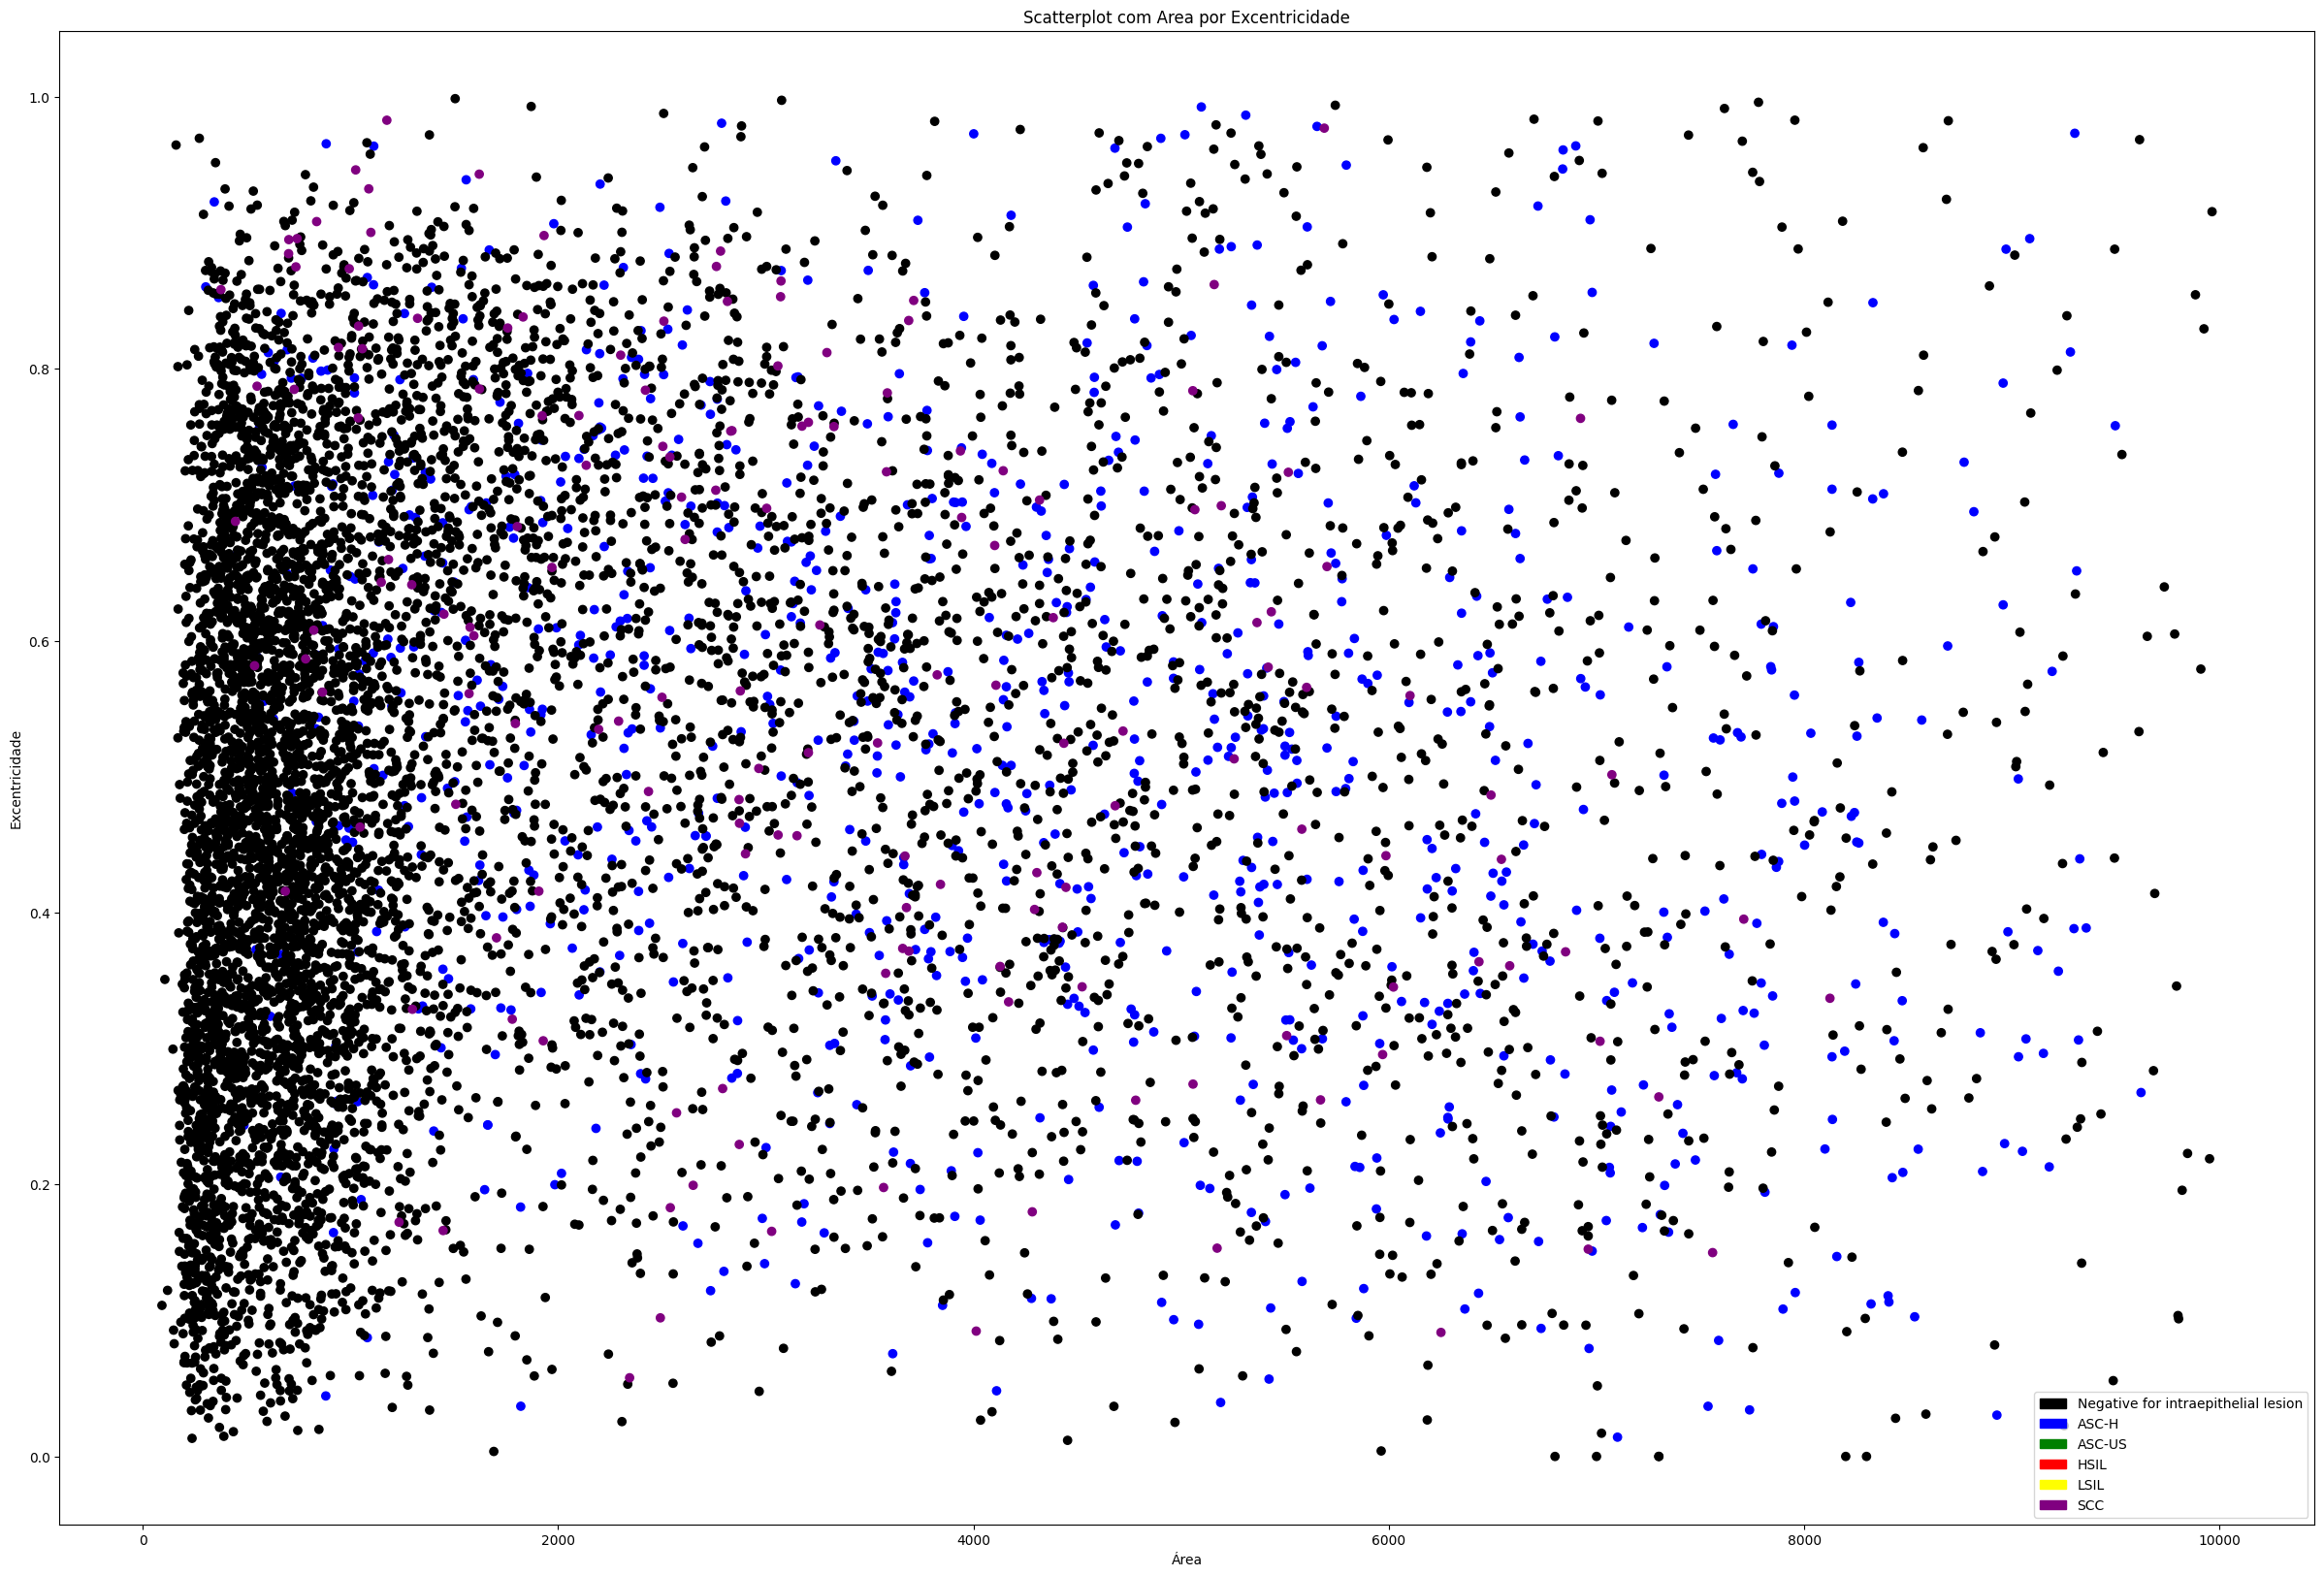

In [9]:
# df = pd.read_csv('csv_pt2.csv')
# df = pd.read_csv('csv_pt2_binario.csv')

# df_filter = df[df["excentricidade"]<10 ]
df_filter = df

cores = {'Negative for intraepithelial lesion': 'black', 'ASC-H': 'blue', "ASC-US":"green", 'HSIL': 'red', 'LSIL': 'yellow','SCC': 'purple',}
# cores = {'Negativo': 'black', 'Positivo': 'blue'}

# Adicionar uma coluna 'Cor' com as cores correspondentes às classes
df_filter['Cor'] = df_filter['label'].map(cores)
plt.figure(figsize=(30, 20))

# Plotar o scatterplot
plt.scatter(df_filter['area'], df_filter['excentricidade'], c=df_filter['Cor'], label=df_filter['label'])

# Tamanho da Figura

# Adicionar rótulos e título
plt.xlabel('Área')
plt.ylabel('Excentricidade')
plt.title('Scatterplot com Area por Excentricidade')

# Criando patches das legendas
patches = [mpatches.Patch(color=color, label=label) for label, color in cores.items()]

# intervalos_y = [15, 25, 55, 115, 125, 155, 215, 225, 255, 315, 325, 355, 415, 425, 455, 515, 525, 555]
# plt.yticks(intervalos_y)
# Adicionar uma legenda
plt.legend(handles=patches)

# Exibir o gráfico
plt.show()

### Calculando Mahalanobis 6 Classes

In [10]:
df = pd.read_csv('../csv_pt2_categorical.csv')
df

,id_cel,label,area,compacidade,excentricidade
0,10,ASC-H,2639,0.2718,0.594165
1,10000,ASC-H,1081,0.5675,0.867085
2,10001,ASC-H,2580,0.4428,0.748014
3,10002,ASC-H,2445,0.5443,0.778005
4,10003,ASC-H,1401,0.9106,0.239338
...,...,...,...,...,...
7860,8128,SCC,3677,0.3981,0.403675
7861,93,SCC,2420,0.3690,0.784196
7862,94,SCC,737,0.6035,0.874912
7863,95,SCC,703,0.6004,0.894963


In [11]:
# Dividindo em treino e teste
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)


In [12]:
train_df

,id_cel,label,area,compacidade,excentricidade
6977,7272,Negative for intraepithelial lesion,2191,0.5024,0.549493
3518,3065,Negative for intraepithelial lesion,1077,0.7673,0.579417
415,9076,ASC-H,8134,0.6507,0.758551
1755,1097,Negative for intraepithelial lesion,515,0.8663,0.432700
7088,738,Negative for intraepithelial lesion,6306,0.3533,0.651140
...,...,...,...,...,...
5226,5489,Negative for intraepithelial lesion,1629,0.9053,0.103310
5390,575,Negative for intraepithelial lesion,258,0.9170,0.572794
860,9873,ASC-H,7675,0.3573,0.282206
7603,9824,Negative for intraepithelial lesion,4815,0.5391,0.929019


In [13]:
def calcular_estatisticas_por_classe(df):
    estatisticas_por_classe = {}
    for classe in df['label'].unique():
        classe_df = df[df['label'] == classe]
        
        # Converta as colunas para números
        numeric_columns = ['area', 'compacidade', 'excentricidade']
        for col in numeric_columns:
            classe_df[col] = pd.to_numeric(classe_df[col], errors='coerce')
        
        estatisticas_por_classe[classe] = {
            'media': np.mean(classe_df[numeric_columns], axis=0),
            'covariancia': np.cov(classe_df[numeric_columns], rowvar=False)
        }
    return estatisticas_por_classe
# Calcule as estatísticas para o conjunto de treinamento
estatisticas_treinamento = calcular_estatisticas_por_classe(train_df)


for each in estatisticas_treinamento.items():
  print(each)

('Negative for intraepithelial lesion', {'media': area              1820.222427
compacidade          0.681635
excentricidade       0.493977
dtype: float64, 'covariancia': array([[ 3.81466874e+06, -3.25081504e+02,  4.10301853e+01],
       [-3.25081504e+02,  6.46098953e-02, -1.86752938e-02],
       [ 4.10301853e+01, -1.86752938e-02,  4.64222443e-02]])})
('ASC-H', {'media': area              4341.465116
compacidade          0.480576
excentricidade       0.518788
dtype: float64, 'covariancia': array([[ 5.04851113e+06, -1.85889000e+02, -1.01599435e+02],
       [-1.85889000e+02,  3.81622974e-02,  5.94173927e-03],
       [-1.01599435e+02,  5.94173927e-03,  4.39977099e-02]])})
('SCC', {'media': area              3422.369231
compacidade          0.437556
excentricidade       0.565767
dtype: float64, 'covariancia': array([[ 3.75409064e+06, -1.63800432e+02, -1.86527024e+02],
       [-1.63800432e+02,  3.30560986e-02,  3.75641664e-05],
       [-1.86527024e+02,  3.75641664e-05,  5.34610099e-02]])})


C:\Users\joaopc\AppData\Local\Temp\ipykernel_9556\955804924.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classe_df[col] = pd.to_numeric(classe_df[col], errors='coerce')
C:\Users\joaopc\AppData\Local\Temp\ipykernel_9556\955804924.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classe_df[col] = pd.to_numeric(classe_df[col], errors='coerce')
C:\Users\joaopc\AppData\Local\Temp\ipykernel_9556\955804924.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

Acurácia: 0.6064844246662429
Matriz de Confusão:
[[108  43  43]
 [227 829 292]
 [  7   7  17]]


ValueError: The number of FixedLocator locations (3), usually from a call to set_ticks, does not match the number of labels (6).

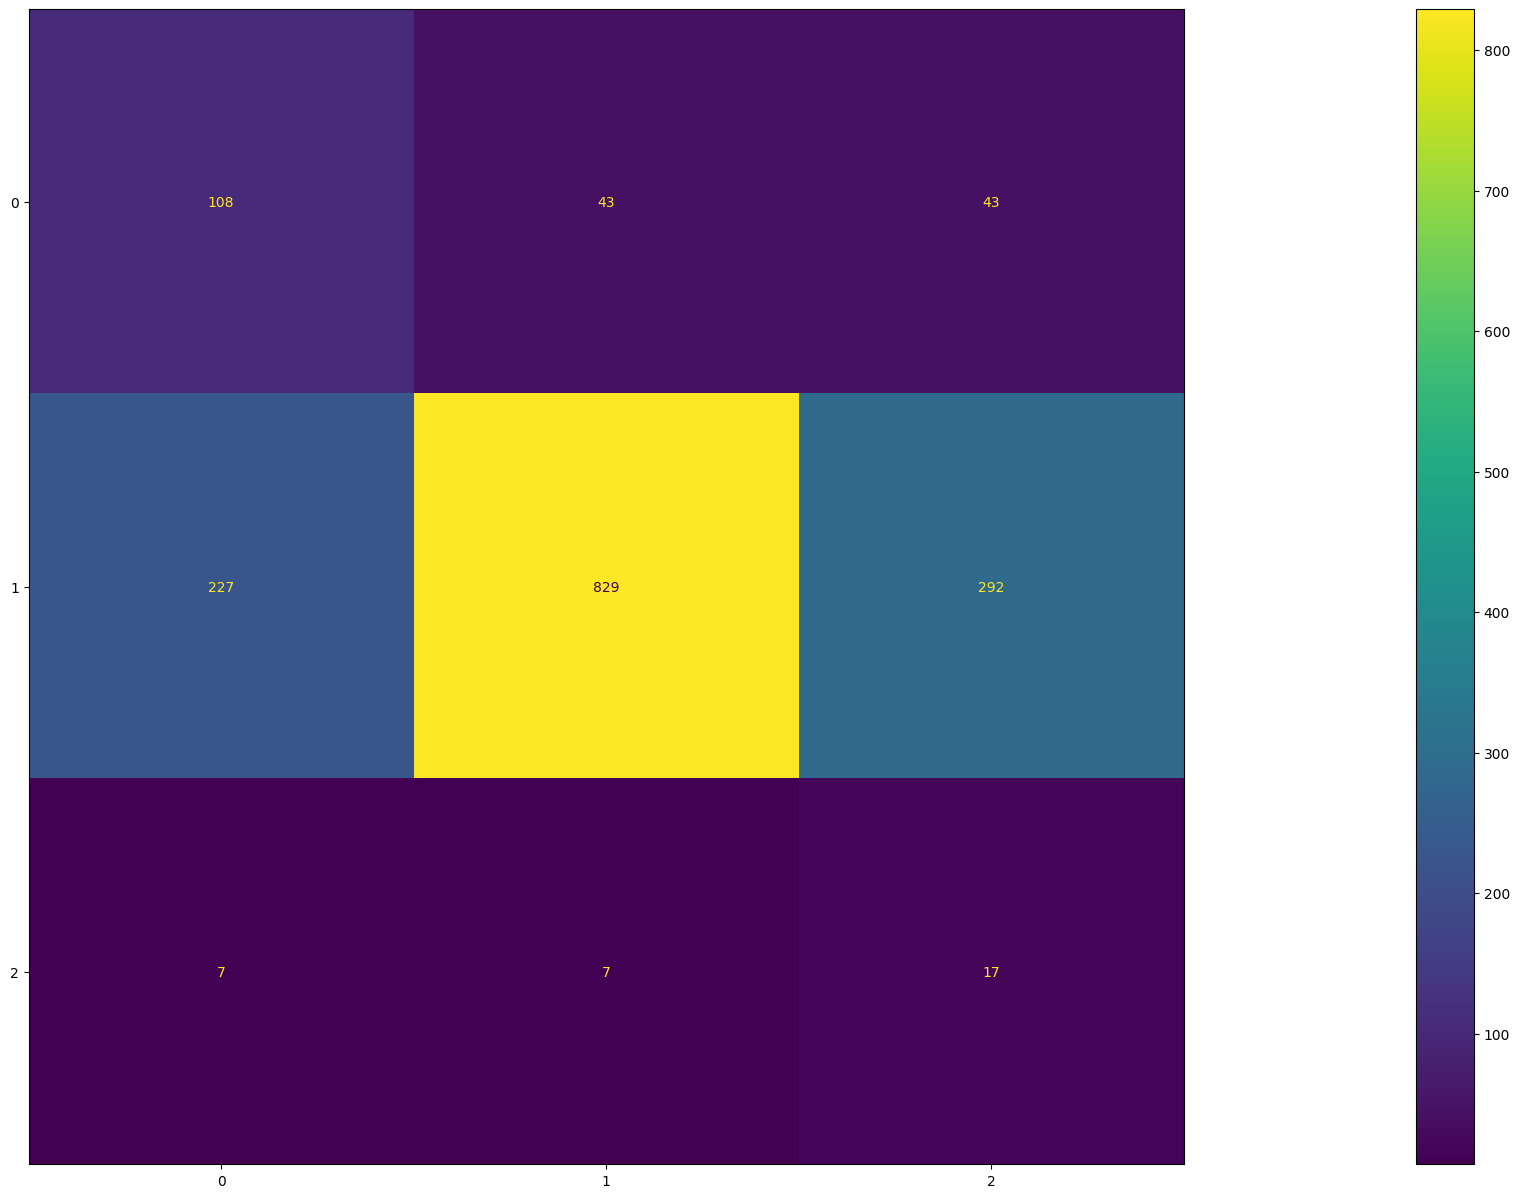

In [14]:
from scipy.spatial.distance import mahalanobis

# Função para classificar uma amostra usando distância de Mahalanobis
def classificar_mahalanobis(amostra, estatisticas_por_classe):
    distancias = {}
    for classe, estatisticas in estatisticas_por_classe.items():
        distancias[classe] = mahalanobis(amostra, estatisticas['media'], np.linalg.inv(estatisticas['covariancia']))
    return min(distancias, key=distancias.get)


test_df['predicao_mahalanobis'] = test_df[['area', 'compacidade', 'excentricidade']].apply(
    lambda x: classificar_mahalanobis(x, estatisticas_treinamento),
    axis=1
)


# Acurácia
acuracia = accuracy_score(test_df['label'], test_df['predicao_mahalanobis'])
print(f'Acurácia: {acuracia}')

# Matriz de Confusão
matriz_confusao = confusion_matrix(test_df['label'], test_df['predicao_mahalanobis'])

y_true = test_df['label']
y_pred = test_df['predicao_mahalanobis']

# Calcule a matriz de confusão
matriz_confusao = confusion_matrix(y_true, y_pred)

# Imprima a matriz de confusão
print('Matriz de Confusão:')
print(matriz_confusao)


labels = ["ASC-H", "ASC-US", "HSIL", "LSIL", "Negative", "SCC"] # Substitua pelo seu conjunto específico de rótulos
disp = ConfusionMatrixDisplay(confusion_matrix=matriz_confusao, display_labels=labels)
fig, ax = plt.subplots(figsize=(60,15))
disp.plot(ax=ax)

### Cross Validation Mahanalobis

In [19]:
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.spatial.distance import mahalanobis
class MahalanobisClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, estatisticas_por_classe):
        self.estatisticas_por_classe = estatisticas_por_classe

    def fit(self, X, y=None):
        return self  # Não é necessário treinamento separado

    def predict(self, X):
        y_pred = []

        for _, amostra in X.iterrows():
            distancias = {}

            for classe, estatisticas in self.estatisticas_por_classe.items():
                distancias[classe] = mahalanobis(
                    amostra[['area', 'compacidade', 'excentricidade']],
                    estatisticas['media'],
                    np.linalg.inv(estatisticas['covariancia'])
                )

            predicao = min(distancias, key=distancias.get)
            y_pred.append(predicao)

        return y_pred

Acurácia: 0.48287819679237104
Matriz de Confusão:
[[ 15  16  84  13  28  34]
 [  4  13  32   9  51  21]
 [ 25   9 216  12  41  37]
 [ 19  16  99  27  65  46]
 [ 26  16 216  13 834 239]
 [  3   1  12   2   4   9]]


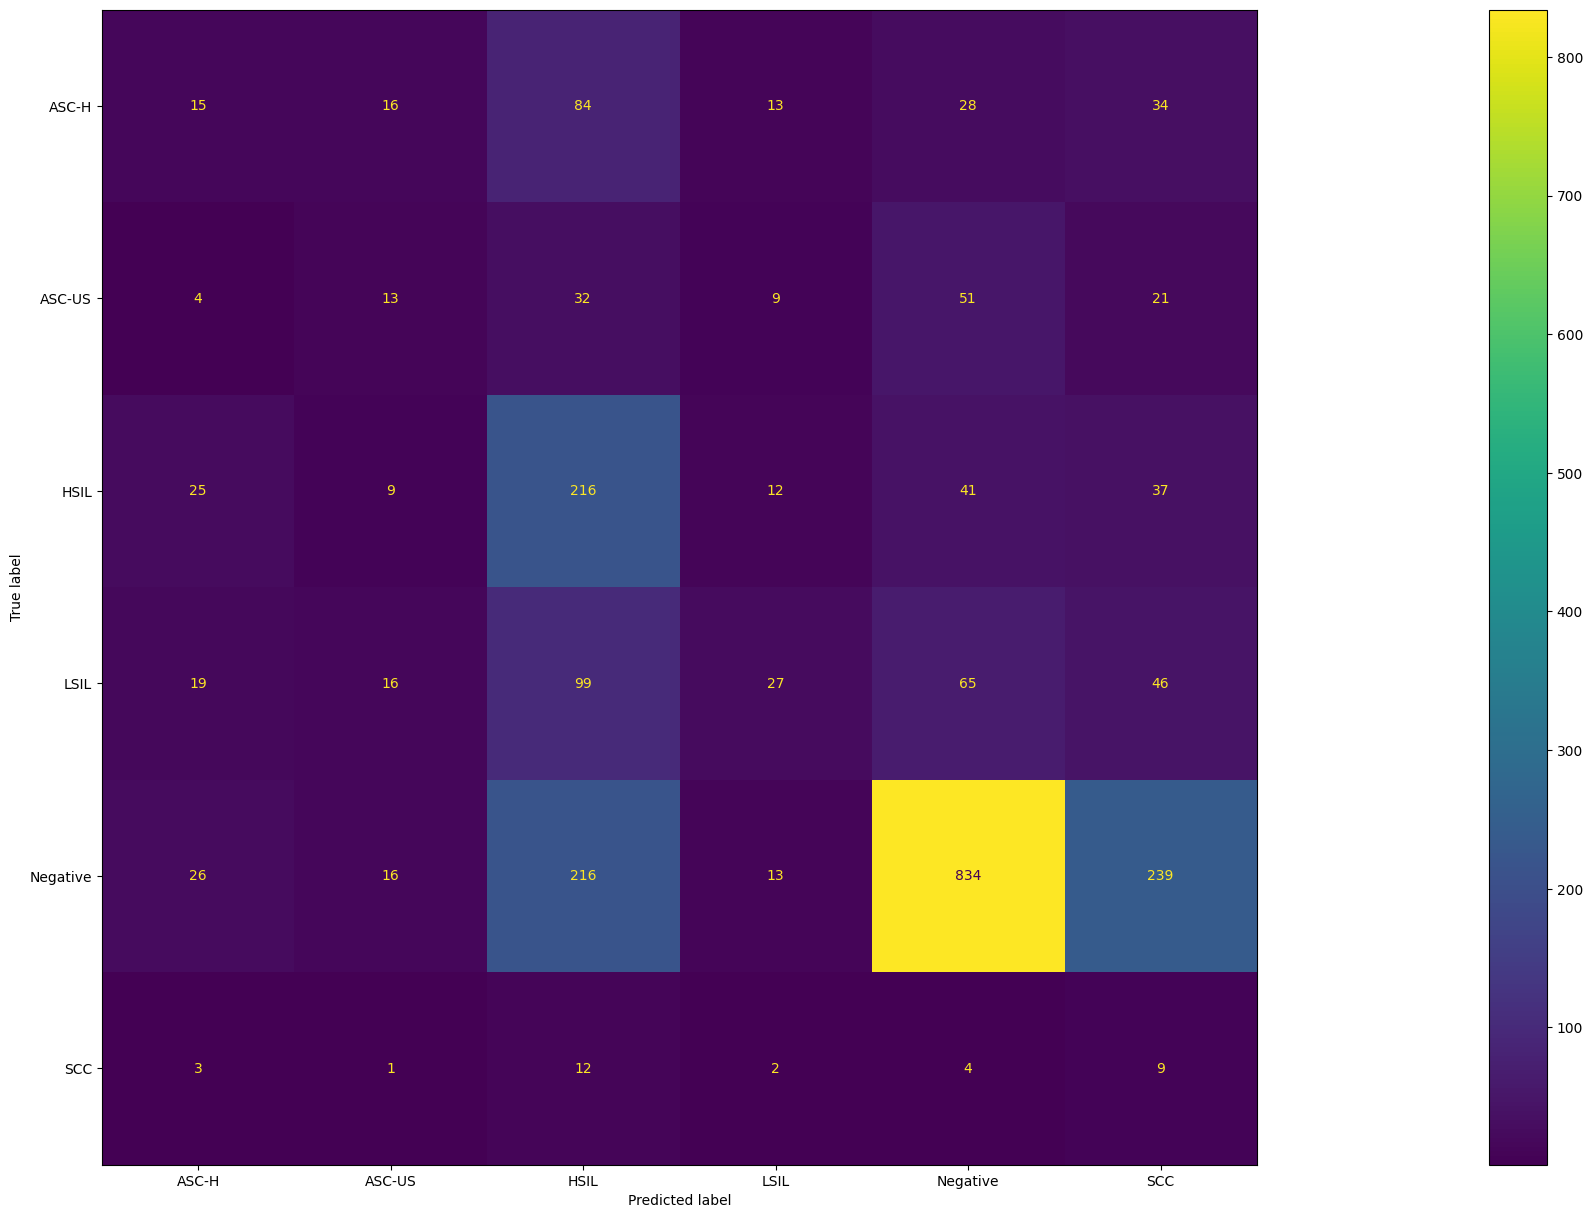

In [20]:
mahalanobis_estimator = MahalanobisClassifier(estatisticas_por_classe=estatisticas_treinamento)


y_pred = cross_val_predict(mahalanobis_estimator, 
                            X=test_df[['area', 'compacidade', 'excentricidade']],  # Conjunto de teste
                            y=test_df['label'], 
                            cv=6)  # Número de folds para a validação cruzada

# Acurácia
acuracia = accuracy_score(test_df['label'], y_pred=y_pred)
print(f'Acurácia: {acuracia}')

# Matriz de Confusão
y_true = test_df['label']

# Calcule a matriz de confusão
matriz_confusao = confusion_matrix(y_true, y_pred)

# Imprima a matriz de confusão
print('Matriz de Confusão:')
print(matriz_confusao)



labels = ["ASC-H", "ASC-US", "HSIL", "LSIL", "Negative", "SCC"]
disp = ConfusionMatrixDisplay(confusion_matrix=matriz_confusao, display_labels=labels)
fig, ax = plt.subplots(figsize=(60,15))
disp.plot(ax=ax)


### Balanceando dataset

In [ ]:
from tqdm import tqdm

def aumentar_dados(dataset_path, output_path, angulos):
    # Certifique-se de que o diretório de saída exista
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    # Lista todos os arquivos de imagem no diretório de entrada
    imagens = [f for f in os.listdir(dataset_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

    # Itera sobre as imagens e gera a quantidade desejada de novos dados
    for imagem_nome in tqdm(imagens, desc='Aumentando dados'):
        imagem_path = os.path.join(dataset_path, imagem_nome)
        img = cv2.imread(imagem_path)

        # Espelha horizontal
        img_flip_horizontal = cv2.flip(img, 1)
        salvar_imagem(output_path, imagem_nome, 'flip_horizontal', img_flip_horizontal)

        # Espelha verticalmente
        img_flip_vertical = cv2.flip(img, 0)
        salvar_imagem(output_path, imagem_nome, 'flip_vertical', img_flip_vertical)
        
        for angulo in angulos:
            # Gira a imagem conforme o ângulo especificado
            img_rotacionada = rotacionar_imagem(img, angulo)
            salvar_imagem(output_path, imagem_nome, f'rotate_{angulo}', img_rotacionada)

def rotacionar_imagem(imagem, angulo):
    altura, largura = imagem.shape[:2]
    ponto_rotacao = (largura // 2, altura // 2)
    matriz_rotacao = cv2.getRotationMatrix2D(ponto_rotacao, angulo, 1.0)
    imagem_rotacionada = cv2.warpAffine(imagem, matriz_rotacao, (largura, altura), flags=cv2.INTER_LINEAR)
    return imagem_rotacionada

def salvar_imagem(output_path, original_nome, operacao, imagem):
    # Cria o nome do arquivo para a imagem gerada
    novo_nome = f"{os.path.splitext(original_nome)[0]}_{operacao}.jpg"
    novo_path = os.path.join(output_path, novo_nome)

    # Salva a imagem gerada
    cv2.imwrite(novo_path, imagem)
    
    
dataset_path = '../data/segmentation_dataset_balanceado/SCC/'
output_path = '../data/segmentation_dataset_balanceado/SCC/'
angulos = [30 * i for i in range(10)] 
print(angulos)
aumentar_dados(dataset_path, output_path, angulos=angulos)